# Getting started by Example: Optimization of Reaction Conditions

In this example we take on a reaction condition optimization problem:
Suppose you have some simple reaction where two ingredients $A$ and $B$ react to $C$ as

$$
A + B  \rightarrow C
$$

Our reactors can be temperature controlled, and we can use different solvents. Furthermore, we can dilute our reaction mixture by using a different solvent volume. 
parameters like the **temperature** or the **solvent volume** are **continuous paramters**, where we have to set our ranges
$$
0^{\, \circ} \text{C}  \, \le T \le \,  60^{\, \circ} \text{C} 
$$

$$
20 \, \text{ml} \le V_{solvent} \le 90 \,\text{ml} 
$$

Parameters like the use of **which solvent**, where there's a choice of either this or that, are **categorical parameters**
$$
\text{Solvent} \, S \,  \in  \, \{ \text{MeOH, THF, Dioxane} \}
$$


For now we only wish top optimize the Reaction yield, making this a **single objective optimization problem**.

$$
\max _{T,V,S} \text{ReactionYield}(T,V,S)
$$

Below we'll see how to perform such an optimization using bofire, Utilizing a **Single Objective Bayesian Optimization (SOBO)** Strategy 

In [ ]:
# python imports we'll need in this notebook
import os
import time

import numpy as np
import pandas as pd


SMOKE_TEST = os.environ.get("SMOKE_TEST")
print(f"SMOKE_TEST: {SMOKE_TEST}")

SMOKE_TEST: True


## Setting up the optimization problem as a **Reaction Domain**

In [ ]:
from bofire.data_models.domain.api import Domain, Inputs, Outputs
from bofire.data_models.features.api import (  # we won't need all of those.
    CategoricalInput,
    ContinuousInput,
    ContinuousOutput,
)

In [ ]:
# We wish the temperature of the reaction to be between 0 and 60 °C
temperature_feature = ContinuousInput(key="Temperature", bounds=[0.0, 60.0], unit="°C")

# Solvent Amount
solvent_amount_feature = ContinuousInput(key="Solvent Volume", bounds=[20, 90])

# we have a couple of solvents in stock, which we'd liek to use
solvent_type_feature = CategoricalInput(
    key="Solvent Type", categories=["MeOH", "THF", "Dioxane"]
)


# gather all individual features
input_features = Inputs(
    features=[
        temperature_feature,
        solvent_type_feature,
        solvent_amount_feature,
    ]
)

In [ ]:
# outputs: we wish to maximize the Yield
# import Maximize Objective to tell the optimizer you wish to optimize
from bofire.data_models.objectives.api import MaximizeObjective


objective = MaximizeObjective(
    w=1.0,
)
yield_feature = ContinuousOutput(key="Yield", objective=objective)
# create an output feature
output_features = Outputs(features=[yield_feature])

In [ ]:
objective

MaximizeObjective(type='MaximizeObjective', w=1.0, bounds=(0, 1))

In [ ]:
# we now have
print("input_features:", input_features)
print("output_features:", output_features)

input_features: type='Inputs' features=[ContinuousInput(type='ContinuousInput', key='Temperature', unit='°C', bounds=(0.0, 60.0), local_relative_bounds=None, stepsize=None), CategoricalInput(type='CategoricalInput', key='Solvent Type', categories=['MeOH', 'THF', 'Dioxane'], allowed=[True, True, True]), ContinuousInput(type='ContinuousInput', key='Solvent Volume', unit=None, bounds=(20.0, 90.0), local_relative_bounds=None, stepsize=None)]
output_features: type='Outputs' features=[ContinuousOutput(type='ContinuousOutput', key='Yield', unit=None, objective=MaximizeObjective(type='MaximizeObjective', w=1.0, bounds=(0, 1)))]


In [ ]:
# The domain is now the object that holds the entire optimization problem / problem definition.
domain = Domain(
    inputs=input_features,
    outputs=output_features,
)

In [ ]:
# you can now have a pretty printout of your domain via
(domain.inputs + domain.outputs).get_reps_df()

,Type,Description
Solvent Volume,ContinuousInput,"[20.0,90.0]"
Temperature,ContinuousInput,"[0.0,60.0]"
Solvent Type,CategoricalInput,3 categories
Yield,ContinuousOutput,ContinuousOutputFeature


In [ ]:
# and you can access your domain features via
for (
    feature_key
) in domain.inputs.get_keys():  # this will get all the feature names and loop over them
    input_feature = domain.inputs.get_by_key(
        feature_key
    )  # we can extract the individual feature object by asking for it by name
    print(feature_key, "|", input_feature)

Solvent Volume | [20.0,90.0]
Temperature | [0.0,60.0]
Solvent Type | 3 categories


In [ ]:
# as well as the output features as
# and you can access your domain features via
for feature_key in (
    domain.outputs.get_keys()
):  # this will get all the feature names and loop over them
    output_feature = domain.outputs.get_by_key(
        feature_key
    )  # we can extract the individual feature object by asking for it by name
    print(feature_key, " | ", output_feature.__repr__())

Yield  |  ContinuousOutput(type='ContinuousOutput', key='Yield', unit=None, objective=MaximizeObjective(type='MaximizeObjective', w=1.0, bounds=(0, 1)))


In [ ]:
(domain.inputs + domain.outputs).get_reps_df()

,Type,Description
Solvent Volume,ContinuousInput,"[20.0,90.0]"
Temperature,ContinuousInput,"[0.0,60.0]"
Solvent Type,CategoricalInput,3 categories
Yield,ContinuousOutput,ContinuousOutputFeature


### Import a toy Reaction to play around with
We've prepared a reaction emulator, which you can use to emulate a real experiment below.

In [ ]:
# Reaction Optimization Notebook util code
T0 = 25
T1 = 100
e0 = np.exp((T1 + 0) / T0)
e60 = np.exp((T1 + 60) / T0)
de = e60 - e0

boiling_points = {  # in °C
    "MeOH": 64.7,
    "THF": 66.0,
    "Dioxane": 101.0,
}
density = {  # in kg/l
    "MeOH": 0.792,
    "THF": 0.886,
    "Dioxane": 1.03,
}
# create dict from individual dicts
descs = {
    "boiling_points": boiling_points,
    "density": density,
}
solvent_descriptors = pd.DataFrame(descs)


# these functions are for faking real experimental data ;)
def calc_volume_fact(V):
    # 20-90
    # max at 75 = 1
    # min at 20 = 0.7
    # at 90=0.5
    x = (V - 20) / 70
    x = 0.5 + (x - 0.75) * 0.1 + (x - 0.4) ** 2
    return x


def calc_rhofact(solvent_type, Tfact):
    #  between 0.7 and 1.1
    x = solvent_descriptors["density"][solvent_type]
    x = (1.5 - x) * (Tfact + 0.5) / 2
    return x.values


def calc_Tfact(T):
    x = np.exp((T1 + T) / T0)
    return (x - e0) / de


# this can be used to create a dataframe of experiments including yields
def create_experiments(domain, nsamples=100, A=25, B=90, candidates=None):
    Tf = domain.inputs.get_by_key("Temperature")
    Vf = domain.inputs.get_by_key("Solvent Volume")
    typef = domain.inputs.get_by_key("Solvent Type")
    yf = domain.outputs.get_by_key("Yield")
    if candidates is None:
        T = np.random.uniform(low=Tf.lower_bound, high=Tf.upper_bound, size=(nsamples,))
        V = np.random.uniform(low=Vf.lower_bound, high=Vf.upper_bound, size=(nsamples,))
        solvent_types = [
            domain.inputs.get_by_key("Solvent Type").categories[np.random.randint(0, 3)]
            for i in range(nsamples)
        ]
    else:
        nsamples = len(candidates)
        T = candidates["Temperature"].values
        V = candidates["Solvent Volume"].values
        solvent_types = candidates["Solvent Type"].values

    Tfact = calc_Tfact(T)
    rhofact = calc_rhofact(solvent_types, Tfact)
    Vfact = calc_volume_fact(V)
    y = A * Tfact + B * rhofact
    y = 0.5 * y + 0.5 * y * Vfact
    # y = y.values
    samples = pd.DataFrame(
        {
            Tf.key: T,
            Vf.key: V,
            yf.key: y,
            typef.key: solvent_types,
            "valid_" + yf.key: np.ones(nsamples),
        },
        # index=pd.RangeIndex(nsamples),
    )
    samples.index = pd.RangeIndex(nsamples)
    return samples


def create_candidates(domain, nsamples=4):
    experiments = create_experiments(domain, nsamples=nsamples)
    candidates = experiments.drop(["Yield", "valid_Yield"], axis=1)
    return candidates


# this is for evaluating candidates that do not yet have a yield attributed to it.
def evaluate_experiments(domain, candidates):
    return create_experiments(domain, candidates=candidates)

In [ ]:
# create some trial experiments (at unitform random)
candidates = create_candidates(domain, nsamples=4)

In [ ]:
candidates

,Temperature,Solvent Volume,Solvent Type
0,58.079994,62.749667,MeOH
1,54.548070,21.571404,MeOH
2,44.572609,65.044737,THF
3,53.383736,70.417429,THF


In [ ]:
# we can evaluate the yield of those candidates
experiments = evaluate_experiments(domain, candidates)

In [ ]:
experiments

,Temperature,Solvent Volume,Yield,Solvent Type,valid_Yield
0,58.079994,62.749667,52.163945,MeOH,1.0
1,54.548070,21.571404,47.515597,MeOH,1.0
2,44.572609,65.044737,30.811281,THF,1.0
3,53.383736,70.417429,42.377953,THF,1.0


# Strategy Setup
a BO Strategy requires a choice of an acquisition function in order to evaluate the quality of new trial candidates. 

In this example we'll use the popular **Expected Improvement (EI)** acqf, which can evaluate the expectation value for obtaining a better function value compared to the current best value by utilizing the regression models' prediction of botht the function value as well as the variance at that point. 

In [ ]:
import bofire.strategies.api as strategies
from bofire.data_models.acquisition_functions.api import qLogEI
from bofire.data_models.strategies.api import SoboStrategy

In [ ]:
# a single objective BO strategy

sobo_strategy_data_model = SoboStrategy(
    domain=domain,
    acquisition_function=qLogEI(),
)

# map the strategy data model to the actual strategy that has functionality
sobo_strategy = strategies.map(sobo_strategy_data_model)

In [ ]:
# first we fit the model of the strategy

sobo_strategy.tell(experiments)

Each implemented strategy has a `strategy.ask(n)` method implemented, where new experiment candidates can be fetched from.  

In [ ]:
# uncomment and run me to see what's happening!
# sobo_strategy.ask(1)

Since a BO strategy requries an underlying regression model for predictions, it requires a certain amount of initial experiments for it to be able to build such a model.

In order to obtain initial experiments, one way is to (pseudo)randomly sample candidate points in the reaction domain. This can e.g. be done by the RandomStrategy. 

In [ ]:
# a random strategy
from bofire.data_models.strategies.api import RandomStrategy as RandomStrategyModel


random_strategy_model = RandomStrategyModel(domain=domain)
# we have to provide the strategy with our optimization problem so it knows where to sample from.
random_strategy = strategies.map(random_strategy_model)

In [ ]:
domain

Domain(type='Domain', inputs=Inputs(type='Inputs', features=[ContinuousInput(type='ContinuousInput', key='Temperature', unit='°C', bounds=(0.0, 60.0), local_relative_bounds=None, stepsize=None), CategoricalInput(type='CategoricalInput', key='Solvent Type', categories=['MeOH', 'THF', 'Dioxane'], allowed=[True, True, True]), ContinuousInput(type='ContinuousInput', key='Solvent Volume', unit=None, bounds=(20.0, 90.0), local_relative_bounds=None, stepsize=None)]), outputs=Outputs(type='Outputs', features=[ContinuousOutput(type='ContinuousOutput', key='Yield', unit=None, objective=MaximizeObjective(type='MaximizeObjective', w=1.0, bounds=(0, 1)))]), constraints=Constraints(type='Constraints', constraints=[]))

In [ ]:
# let's ask for five random sets of conditions
candidates = random_strategy.ask(5)

you can have a look at the candidates

In [ ]:
candidates

,Solvent Volume,Temperature,Solvent Type
0,75.090131,18.111664,THF
1,26.340833,50.048569,MeOH
2,84.496554,49.440374,MeOH
3,62.219315,27.959654,Dioxane
4,36.527079,6.740230,THF


In order to use those experiments as data foundation of the bo strategy above, the output values of these candidates have to be provided. Herein we'll use a dummy function to evaluate some more or less realistic yields given the proposed input candidates as.

In [ ]:
experiments = evaluate_experiments(domain, candidates)

In [ ]:
experiments

,Temperature,Solvent Volume,Yield,Solvent Type,valid_Yield
0,18.111664,75.090131,16.038616,THF,1.0
1,50.048569,26.340833,39.970295,MeOH,1.0
2,49.440374,84.496554,45.839142,MeOH,1.0
3,27.959654,62.219315,15.311189,Dioxane,1.0
4,6.740230,36.527079,11.390565,THF,1.0


note, that the columns `Yield` and `valid_Yield` have been added. `Yield` contains the actual output, whereas `valid_Yield` labels the experiment as valid w.r.t. this respective measured output. 

This info can now be given to the bo strategy so it can use it to fit the underlying regression model it utilizes via the `strategy.tell()` method.

In [ ]:
t1 = time.time()
sobo_strategy.tell(experiments, replace=True, retrain=True)
print(f"fit took {(time.time()-t1):.2f} seconds")

fit took 0.25 seconds


Using this data we can now get a proposal for a next point to evaluate via the `sobo_strategy.ask(1)` method.

In [ ]:
t1 = time.time()
new_candidate = sobo_strategy.ask(1)
print(f"SOBO step took {(time.time()-t1):.2f} seconds")

SOBO step took 0.66 seconds


This ask call now takes way longer, since first a GP model is fitted to the data, and the acquisition function **EI** is optimized to obtain the new proposed candidiates. Note that the predictied yield and standard deviation, as well as desirability function value (the underlying value the optimizer sees) are provided in the new_candidate dataframe.

In [ ]:
new_candidate

,Solvent Volume,Temperature,Solvent Type,Yield_pred,Yield_sd,Yield_des
0,90.0,26.953909,MeOH,44.597389,3.30191,44.597389


## Optimization Loop
With this `strategy.ask()` and `strategy.tell()` we can now do our optimization loop, where after each new proposal, the conditions obtained from `ask` are evaluated and added to the known datapoints via `tell`. This requires to refit the underling model in each step.


In [ ]:
experimental_budget = 10
i = 0
# in case of smoke_test we don't run the actual optimization loop ...
done = False if not SMOKE_TEST else True

while not done:
    i += 1
    t1 = time.time()
    # ask for a new experiment
    new_candidate = sobo_strategy.ask(1)
    new_experiment = evaluate_experiments(domain, new_candidate)
    sobo_strategy.tell(new_experiment)
    print(f"Iteration took {(time.time()-t1):.2f} seconds")
    # inform the strategy about the new experiment
    # experiments = pd.concat([experiments,new_experiment],ignore_index=True)
    if i > experimental_budget:
        done = True

### investigating results

In [ ]:
# you have access to the experiments here
sobo_strategy.experiments

,Temperature,Solvent Volume,Yield,Solvent Type,valid_Yield
0,18.111664,75.090131,16.038616,THF,True
1,50.048569,26.340833,39.970295,MeOH,True
2,49.440374,84.496554,45.839142,MeOH,True
3,27.959654,62.219315,15.311189,Dioxane,True
4,6.740230,36.527079,11.390565,THF,True


<Axes: >

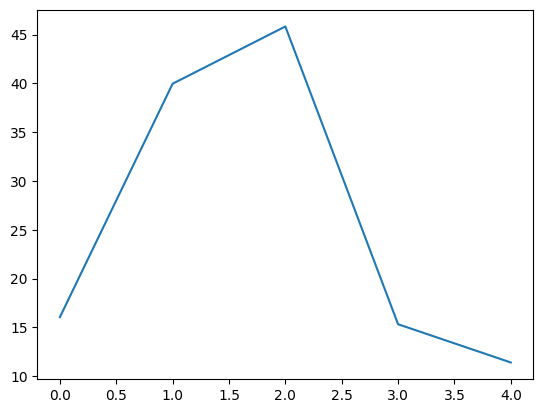

In [ ]:
# quick plot of yield vs. Iteration
sobo_strategy.experiments["Yield"].plot()

### Exercises: 
* further analyze of the experiments. 
    * plot of Iteration vs. Y and best observed Y
    * evaluation of final model w.r.t. Optimal conditions
    * plot of final models' mean and variance as a function of the input parameters, perhaps different plots for each solvent, or in 3d as slices